# This notebook is to evaluate network performance on test shots

In [1]:
# imports
from scipy.io import loadmat
from tqdm import tqdm
import os
from os.path import join
import matplotlib.pyplot as plt
CM = 'inferno'
CM_R = 'inferno_r'
plt.rcParams['image.cmap'] = CM_R

In [2]:
# import numpy as np

# # random cell to show the activation function
# def swish_act(x, β):
#     return x * (1 / (1 + np.exp(-β * x)))

# xs = np.linspace(-4, 4, 1000)
# βs = [0.1, 0.5, 1, 2, 5]
# plt.figure(figsize=(6, 4))
# for β in βs:
#     plt.plot(xs, swish_act(xs, β), label=f'β={β}', linewidth=2)
# plt.title('Swish Activation Function')
# plt.xlabel('x')
# plt.ylabel('Swish(x)')
# plt.legend()
# plt.savefig('swish_activation.png', dpi=300, bbox_inches='tight')
# plt.show()


In [3]:
# let's first see what shots we have
SHOTS_DIR = 'test_shots'
SHOTS_NET_DIR = 'test_shots_net'
os.makedirs(SHOTS_NET_DIR, exist_ok=True)

# list all the files inside
SHOT_FILES = os.listdir(SHOTS_DIR)
SHOT_NAMES = [f.split('.')[0] for f in SHOT_FILES if f.endswith('.mat')]
print(f'Found {len(SHOT_NAMES)} shots: {SHOT_NAMES}')

# # speed up, keep only the first 2
# SHOT_NAMES, SHOT_FILES = SHOT_NAMES[:2], SHOT_FILES[:2]
# print(f'Using {len(SHOT_NAMES)} shots: {SHOT_NAMES}')

Found 2 shots: ['79742', '78071']


In [4]:
# run matlab inference on each shot
for s, sn in zip(SHOT_FILES, SHOT_NAMES):
    print(f'Running matlab inference on {s}...')
    command_linux = f'matlab -nosplash -nodesktop -r "run_net_on_shot({sn}, \'{SHOTS_NET_DIR}\'); exit;"'
    command_mac = f'/Applications/MATLAB_R2024b.app/bin/matlab -nosplash -nodesktop -r "run_net_on_shot({sn}, \'{SHOTS_NET_DIR}\'); exit;"'
    # os.system(command_linux)
    os.system(command_mac)

Running matlab inference on 79742.mat...



                            < M A T L A B (R) >
                  Copyright 1984-2024 The MathWorks, Inc.
                  R2024b (24.2.0.2712019) 64-bit (maca64)
                              August 22, 2024

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
Running network on shot 79742, saving in test_shots_net
Using model path: /Users/mg/repos/tcv_eq/onnx_net_forward/net.onnx
Loading ONNX model from: /Users/mg/repos/tcv_eq/onnx_net_forward/net.onnx ... Success.
Loaded shot data from: test_shots/79742.mat
Packed inputs size: [136 1725]
Control points: 10
Elapsed time for shot 79742: 1.72 seconds
Saved results to: test_shots_net/79742_net.mat
ONNX Runtime session cleaned up.
Running matlab inference on 78071.mat...



                            < M A T L A B (R) >
                  Copyright 1984-2024 The MathWorks, Inc.
                  R2024b (24.2.0.2712019) 64-bit (maca64)
                              August 22, 2024

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
Running network on shot 78071, saving in test_shots_net
Using model path: /Users/mg/repos/tcv_eq/onnx_net_forward/net.onnx
Loading ONNX model from: /Users/mg/repos/tcv_eq/onnx_net_forward/net.onnx ... Success.
Loaded shot data from: test_shots/78071.mat
Packed inputs size: [136 1727]
Control points: 10
Elapsed time for shot 78071: 1.70 seconds
Saved results to: test_shots_net/78071_net.mat
ONNX Runtime session cleaned up.


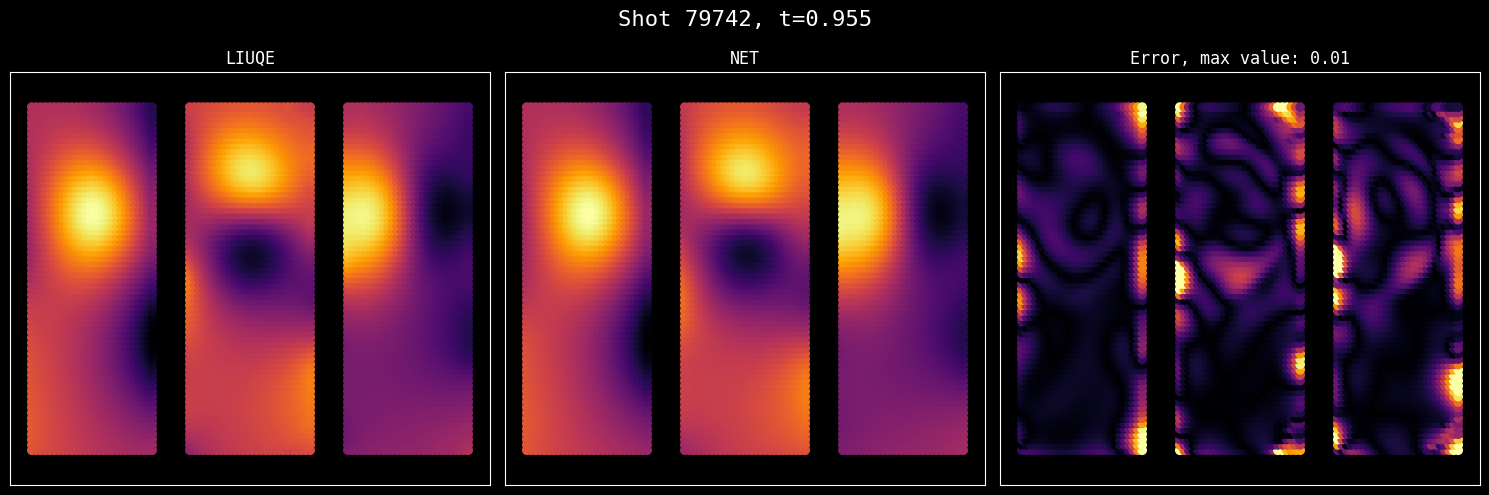

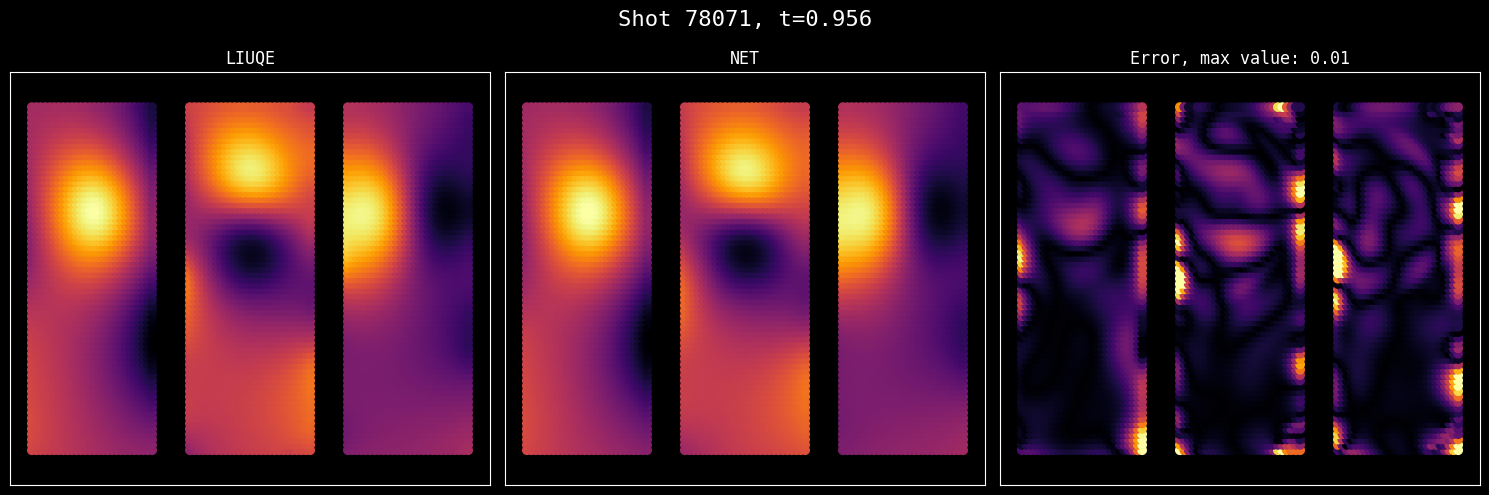

In [26]:
# plotting time baby
import numpy as np
from utils import plot_vessel

g = loadmat('tcv_params/grid.mat')
r, z = g['r'].flatten(), g['z'].flatten()
rr, zz = np.meshgrid(r, z)
rr, zz = rr.flatten(), zz.flatten()

for s, sn in zip(SHOT_FILES, SHOT_NAMES):
    # load
    gt = loadmat(join(SHOTS_DIR, s))
    net = loadmat(join(SHOTS_NET_DIR, f'{sn}_net.mat'))

    ri = 1000

    gFx = gt['Fx']
    gBr = gt['Br']
    gBz = gt['Bz']

    nFx = net['Fx']
    nBr = net['Br']
    nBz = net['Bz']

    t = gt['t'].flatten()

    # range
    mFx, MFx = np.min(gFx, axis=(0, 1)), np.max(gFx, axis=(0, 1))
    mBr, MBr = np.min(gBr), np.max(gBr) 
    mBz, MBz = np.min(gBz), np.max(gBz) 
    rFx = MFx - mFx
    rBr = MBr - mBr
    rBz = MBz - mBz
    # # percentage error 
    # eFx = 100*np.abs(gFx - nFx) / rFx
    # eBr = 100*np.abs(gBr - nBr) / rBr
    # eBz = 100*np.abs(gBz - nBz) / rBz
    # absolute error
    eFx = np.abs(gFx - nFx) 
    eBr = np.abs(gBr - nBr)
    eBz = np.abs(gBz - nBz)


    # max_err_val = 5.0  # max percentage error for colorbar
    max_err_val = .01  # max percentage error for colorbar
    δr = 0.7

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1) # plot the ground truth
    sc1 = plt.scatter(rr, zz, c=gFx[..., ri], vmin=mFx[ri], vmax=MFx[ri], cmap=CM_R) 
    sc4 = plt.scatter(rr+δr, zz, c=gBr[..., ri], vmin=mBr, vmax=MBr, cmap=CM_R)
    sc7 = plt.scatter(rr+2*δr, zz, c=gBz[..., ri], vmin=mBz, vmax=MBz, cmap=CM_R)
    plt.title('LIUQE')
    plt.axis('equal'), plt.grid(False), plt.xticks([]), plt.yticks([])

    plt.subplot(1, 3, 2) # plot the network output
    sc2 = plt.scatter(rr, zz, c=nFx[..., ri], vmin=mFx[ri], vmax=MFx[ri], cmap=CM_R)
    sc5 = plt.scatter(rr+δr, zz, c=nBr[..., ri], vmin=mBr, vmax=MBr, cmap=CM_R)
    sc8 = plt.scatter(rr+2*δr, zz, c=nBz[..., ri], vmin=mBz, vmax=MBz, cmap=CM_R)
    plt.title('NET')
    plt.axis('equal'), plt.grid(False), plt.xticks([]), plt.yticks([])

    plt.subplot(1, 3, 3) # plot the error
    sc3 = plt.scatter(rr, zz, c=eFx[..., ri], vmin=0, vmax=max_err_val, cmap=CM)
    sc6 = plt.scatter(rr+δr, zz, c=eBr[..., ri], vmin=0, vmax=max_err_val, cmap=CM)
    sc9 = plt.scatter(rr+2*δr, zz, c=eBz[..., ri], vmin=0, vmax=max_err_val, cmap=CM)
    plt.axis('equal'), plt.grid(False), plt.xticks([]), plt.yticks([])
    plt.title(f'Error, max value: {max_err_val:.2f}')

    plt.suptitle(f'Shot {sn}, t={t[ri]:.3f}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [6]:
# assert False, "End of the code snippet"

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import display, HTML
# import matplotlib as mpl
# mpl.rcParams['animation.embed_limit'] = 50  # value is in MB


# g = loadmat('tcv_params/grid.mat')
# r, z = g['r'].flatten(), g['z'].flatten()
# rr, zz = np.meshgrid(r, z)
# rr, zz = rr.flatten(), zz.flatten()

# decimate = 1
# max_err_val = 3
# fps = 30.0

# for s, sn in zip(SHOT_FILES, SHOT_NAMES):
#     # load data
#     gt = loadmat(join(SHOTS_DIR, s))
#     net = loadmat(join(SHOTS_NET_DIR, f'{sn}_net.mat'))

#     gFx = gt['Fx']
#     gBr = gt['Br']
#     gBz = gt['Bz']
#     nFx = net['Fx']
#     nBr = net['Br']
#     nBz = net['Bz']
#     rq, zq = gt['rq'], gt['zq']
#     t = gt['t'].flatten()

#     # decimate
#     gFx, gBr, gBz, nFx, nBr, nBz, t, rq, zq = map(lambda x: x[..., ::decimate], (gFx, gBr, gBz, nFx, nBr, nBz, t, rq, zq))

#     # range
#     mFx, MFx = np.min(gFx,axis=(0,1)), np.max(gFx, axis=(0, 1))

#     mBr, MBr = np.min(gBr), np.max(gBr) 
#     mBz, MBz = np.min(gBz), np.max(gBz) 
#     rFx = MFx - mFx
#     rBr = MBr - mBr
#     rBz = MBz - mBz

#     # precompute error percentage
#     eFx = 100 * np.abs(gFx - nFx) / rFx
#     eBr = 100 * np.abs(gBr - nBr) / rBr
#     eBz = 100 * np.abs(gBz - nBz) / rBz

#     n_frames = gFx.shape[-1]

#     fig = plt.figure(figsize=(16, 9))
#     axs = [plt.subplot(3, 1, i + 1) for i in range(9)]
#     scatters, colorbars, plots = [], [], []

#     # Initial plot setup
#     def init():
#         for ax in axs:
#             ax.clear()
#             plot_vessel(ax=ax)
#             ax.axis('equal')
#             ax.grid(False)
#             plots.append(ax.plot(rq[:,0], zq[:,0], '--w', lw=1, alpha=0.5))  # LCFS line

#         scatters.append(axs[0].scatter(rr, zz, c=gFx[..., 0], cmap=CM_R))
#         axs[0].set_title('LIUQUE Fx')
#         colorbars.append(plt.colorbar(scatters[-1], ax=axs[0]))

#         scatters.append(axs[1].scatter(rr, zz, c=nFx[..., 0], cmap=CM_R))
#         axs[1].set_title('Net Fx')
#         colorbars.append(plt.colorbar(scatters[-1], ax=axs[1]))

#         scatters.append(axs[2].scatter(rr, zz, c=eFx[..., 0], vmin=0, vmax=max_err_val, cmap=CM))
#         axs[2].set_title('Error % Fx')
#         colorbars.append(plt.colorbar(scatters[-1], ax=axs[2]))

#         scatters.append(axs[3].scatter(rr, zz, c=gBr[..., 0], vmin=mBr, vmax=MBr, cmap=CM_R))
#         axs[3].set_title('LIUQUE Br')
#         plt.colorbar(scatters[-1], ax=axs[3])

#         scatters.append(axs[4].scatter(rr, zz, c=nBr[..., 0], vmin=mBr, vmax=MBr, cmap=CM_R))
#         axs[4].set_title('Net Br')
#         plt.colorbar(scatters[-1], ax=axs[4])

#         scatters.append(axs[5].scatter(rr, zz, c=eBr[..., 0], vmin=0, vmax=max_err_val, cmap=CM))
#         axs[5].set_title('Error % Br')
#         plt.colorbar(scatters[-1], ax=axs[5])

#         scatters.append(axs[6].scatter(rr, zz, c=gBz[..., 0], vmin=mBz, vmax=MBz, cmap=CM_R))
#         axs[6].set_title('LIUQUE Bz')
#         plt.colorbar(scatters[-1], ax=axs[6])

#         scatters.append(axs[7].scatter(rr, zz, c=nBz[..., 0], vmin=mBz, vmax=MBz, cmap=CM_R))
#         axs[7].set_title('Net Bz')
#         plt.colorbar(scatters[-1], ax=axs[7])

#         scatters.append(axs[8].scatter(rr, zz, c=eBz[..., 0], vmin=0, vmax=max_err_val, cmap=CM))
#         axs[8].set_title('Error % Bz')
#         plt.colorbar(scatters[-1], ax=axs[8])

#         fig.suptitle(f'Shot {sn}, t={t[0]:.3f}/{t[-1]:.3f}', fontsize=16)

#         plt.tight_layout()

#         return scatters

#     def update(ri):
#         # --- Dynamic vmin/vmax for Fx only
#         vmin_gFx = np.min(gFx[..., ri])
#         vmax_gFx = np.max(gFx[..., ri])

#         scatters[0].set_array(gFx[..., ri].flatten())
#         scatters[0].set_clim(vmin_gFx, vmax_gFx)
#         colorbars[0].update_normal(scatters[0])

#         scatters[1].set_array(nFx[..., ri].flatten())
#         # scatters[1].set_clim(vmin_nFx, vmax_nFx)
#         scatters[1].set_clim(vmin_gFx, vmax_gFx)
#         colorbars[1].update_normal(scatters[1])

#         scatters[2].set_array(eFx[..., ri].flatten())
#         # Keep error colorbar fixed from 0 to 1 for clarity

#         scatters[3].set_array(gBr[..., ri].flatten())
#         scatters[4].set_array(nBr[..., ri].flatten())
#         scatters[5].set_array(eBr[..., ri].flatten())
#         scatters[6].set_array(gBz[..., ri].flatten())
#         scatters[7].set_array(nBz[..., ri].flatten())
#         scatters[8].set_array(eBz[..., ri].flatten())

#         # Update plots with LCFS
#         for plot in plots:
#             plot[0].set_data(rq[:, ri], zq[:, ri])

#         fig.suptitle(f'Shot {sn}, t={t[ri]:.3f}/{t[-1]:.3f}', fontsize=16)
#         return scatters

#     # Save to MP4 with progress bar
#     print(f"Rendering animation for shot {sn}...")
#     with tqdm(total=n_frames, desc='Rendering frames', colour='yellow') as pbar:
#         def update_with_progress(i):
#             artists = update(i)
#             pbar.update(1)
#             return artists

#         anim = FuncAnimation(fig, update_with_progress, init_func=init,
#                              frames=n_frames, interval=500/fps, blit=False)
        
#         # display(HTML(anim.to_html5_video()))
#         # display(HTML(anim.to_jshtml()))

#         anim.save(f'{SHOTS_NET_DIR}/{sn}_animation.mp4', extra_args=['-vcodec', 'libx264'])
#         # import subprocess
#         # subprocess.call(['xattr', '-d', 'com.apple.quarantine', f'{SHOTS_NET_DIR}/{sn}_animation.mp4']) # remove quarantine attribute for macOS

#         plt.close(fig)


In [ ]:
# lets select some points along the LCFS (at fixed angles) and plot them
from utils import interp_pts
g = loadmat('tcv_params/grid.mat')
r, z = g['r'].flatten(), g['z'].flatten()
rr, zz = np.meshgrid(r, z)
rr, zz = rr.flatten(), zz.flatten()

# decimate = 2
t_interv = (0.5, 0.6)
max_err_val = 3
fps = 30.0

n_ctrl_pts = 10 # number of control points along the LCFS

nq = 129  # number of points on the LCFS

sep_idxs = np.linspace(0, nq-1, n_ctrl_pts).astype(int)
sep_angles = np.linspace(0, 2*np.pi, n_ctrl_pts, endpoint=False)
print(f'Selected {n_ctrl_pts} control points at indices: {sep_idxs}')


for s, sn in zip(SHOT_FILES, SHOT_NAMES):
    # load data
    liu = loadmat(join(SHOTS_DIR, s))
    net = loadmat(join(SHOTS_NET_DIR, f'{sn}_net.mat'))

    # control points
    rc = [0.7038, 0.6722, 0.6516, 0.7108, 0.9376, 1.0843, 1.0931, 0.9414, 0.8023, 0.6240]
    zc = [-0.1195, 0.1285, 0.3775, 0.6159, 0.6127, 0.4150, 0.1691, -0.0246, -0.7500, -0.1229]
    rc = np.array(rc)
    zc = np.array(zc)
    nc = len(rc)
    cpts = np.stack([rc, zc], axis=1) # [nc, 2] 

    # liuqe values at grid points
    LgFx, LgBr, LgBz = liu['Fxg'], liu['Brg'], liu['Bzg']
    # net values at grid points
    NgFx, NgBr, NgBz = net['Fxg'], net['Brg'], net['Bzg']
    # net values at control points
    NcFx, NcBr, NcBz = net['Fxc'], net['Brc'], net['Bzc']

    t = liu['t'].flatten()

    # find t indexes for the given time interval
    t_idxs = np.where((t >= t_interv[0]) & (t <= t_interv[1]))[0]
    assert len(t_idxs) > 0, f'No time points found in the interval {t_interv} for shot {sn}'
    # select values at the given time interval
    LgFx, LgBr, LgBz, NgFx, NgBr, NgBz, t = map(lambda x: x[..., t_idxs], (LgFx, LgBr, LgBz, NgFx, NgBr, NgBz, t))
    nt = len(t)

    # LIUQUE values at ctrl points (interpolated from the grid at ctrl points)
    LciFx, LciBr, LciBz = np.zeros((nc, nt)), np.zeros((nc, nt)), np.zeros((nc, nt))
    for i in tqdm(range(nt), desc=f'Interpolating LIUQUE for shot {sn}', colour='yellow'):
        LciFx[:, i] = interp_pts(LgFx[..., i], cpts)
        LciBr[:, i] = interp_pts(LgBr[..., i], cpts)
        LciBz[:, i] = interp_pts(LgBz[..., i], cpts)

    # Net values at ctrl points (interpolated from the grid at ctrl points)
    NciFx, NciBr, NciBz = np.zeros((nc, nt)), np.zeros((nc, nt)), np.zeros((nc, nt))
    for i in tqdm(range(nt), desc=f'Interpolating Net for shot {sn}', colour='yellow'):
        NciFx[:, i] = interp_pts(NgFx[..., i], cpts)
        NciBr[:, i] = interp_pts(NgBr[..., i], cpts)
        NciBz[:, i] = interp_pts(NgBz[..., i], cpts)

    ## get the errors
    # liuqe vs net at grid
    ELNgFx = np.abs(LgFx - NgFx)
    ELNgBr = np.abs(LgBr - NgBr)
    ELNgBz = np.abs(LgBz - NgBz)
    # liuqe vs net at ctrl points directly
    ELNcFx = np.abs(LciFx - NciFx)
    ELNcBr = np.abs(LciBr - NciBr)
    ELNcBz = np.abs(LciBz - NciBz)
    # liuque vs net interpolated at ctrl points
    ELNciFx = np.abs(LciFx - NciFx)
    ELNciBr = np.abs(LciBr - NciBr)
    ELNciBz = np.abs(LciBz - NciBz)
    # net directly vs net interpolated at ctrl points
    ENNcFx = np.abs(NciFx - NcFx)
    ENNcBr = np.abs(NciBr - NcBr)
    ENNcBz = np.abs(NciBz - NcBz)

    # print some stats about the errors
    print(f'Shot {sn} - time: [{t[0]:.4f} -> {t[-1]:.4f}]')
    print(f'Error LIUQUE vs Net at grid points: \n'
          f'Fx: {np.mean(ELNgFx):.4f}, Br: {np.mean(ELNgBr):.4f}, Bz: {np.mean(ELNgBz):.4f}')
    print(f'Error LIUQUE vs Net at ctrl points (directly): \n'
          f'Fx: {np.mean(ELNcFx):.4f}, Br: {np.mean(ELNcBr):.4f}, Bz: {np.mean(ELNcBz):.4f}')
    print(f'Error LIUQUE vs Net at ctrl points (interpolated): \n'
          f'Fx: {np.mean(ELNciFx):.4f}, Br: {np.mean(ELNciBr):.4f}, Bz: {np.mean(ELNciBz):.4f}')
    print(f'Error Net at ctrl points (directly) vs (interpolated): \n'
          f'Fx: {np.mean(ENNcFx):.4f}, Br: {np.mean(ENNcBr):.4f}, Bz: {np.mean(ENNcBz):.4f}')

    α = 1
    plot_first_n = 10
    color_cycle = plt.get_cmap('tab20')

    plt.figure(figsize=(16, 9))

    plt.savefig(f'{SHOTS_NET_DIR}/{sn}_control_points.png', bbox_inches='tight', dpi=300)
    plt.show()

    # now let's plot the errors
    α2 = 0.8
    plt.figure(figsize=(16, 9))

    plt.savefig(f'{SHOTS_NET_DIR}/{sn}_control_points_errors.png', bbox_inches='tight', dpi=300)
    plt.show()


Selected 10 control points at indices: [  0  14  28  42  56  71  85  99 113 128]


KeyError: 'Fxg'